In [ ]:
!pip install "qiskit==0.45.1" "qiskit-aer==0.13.3"


In [ ]:
!pip install prototype-zne


In [ ]:
from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi  #
from zne import zne

ZNEEstimator = zne(BackendEstimator)  #
backend = FakeNairobi()
estimator = ZNEEstimator(backend=backend)

In [ ]:
# Cell 0: Imports & dependency check
import sys, os, math, time, copy, random
from dataclasses import dataclass
from typing import List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt

# Import Qiskit + Aer;
HAS_QISKIT = False
HAS_AER = False
try:
    import qiskit
    from qiskit import QuantumCircuit, transpile
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.quantum_info import Statevector, Operator
    HAS_QISKIT = True
    try:
        # Attempt to instantiate AerSimulator to ensure qiskit-aer available
        _ = AerSimulator()
        HAS_AER = True
    except Exception:
        HAS_AER = False
except Exception:
    HAS_QISKIT = False
    HAS_AER = False

# PyTorch for PPO
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.distributions import Categorical
    HAS_TORCH = True
except Exception:
    HAS_TORCH = False

print("HAS_QISKIT:", HAS_QISKIT, "HAS_AER:", HAS_AER, "HAS_TORCH:", HAS_TORCH)
if not (HAS_QISKIT and HAS_AER):
    print("\nNOTE: Qiskit/Aer not fully available. Cells that need realistic noise models will fall back to toy simulator.")
if not HAS_TORCH:
    raise RuntimeError("PyTorch (torch) is required for the PPO implementation. Install with `pip install torch`.")


HAS_QISKIT: True HAS_AER: True HAS_TORCH: True


In [ ]:
# Cell 1: Utility functions - extrapolators (linear, poly2, exponential)
import warnings


def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    a, b = sol[0], sol[1]
    return float(b)

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    lambdas = np.array(lambdas)
    values = np.array(values)
    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift
    if len(lambdas) == 1:
        return float(values[0] - shift)
    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        c = -coefs[0]
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("poly2", poly2_extrapolate),
    2: ("exponential", exponential_extrapolate)
}

In [ ]:
# Cell 2: Circuit generators - XYZ / TFIM Hamiltonian Trotterized circuits (Qiskit ≥1.0)
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

def generate_xyz_hamiltonian_sparse(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """
    Build an XYZ (or TFIM) Hamiltonian in SparsePauliOp form.

    H = Σ_i [ Jx*X_i X_{i+1} + Jy*Y_i Y_{i+1} + Jz*Z_i Z_{i+1} ]
        + Σ_i [ hx*X_i + hy*Y_i + hz*Z_i ]
    with open boundary conditions.
    """
    terms = []
    coeffs = []

    # two-qubit couplings
    for i in range(n_qubits - 1):
        if abs(Jx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            pauli[i + 1] = "X"
            terms.append("".join(pauli))
            coeffs.append(Jx)
        if abs(Jy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            pauli[i + 1] = "Y"
            terms.append("".join(pauli))
            coeffs.append(Jy)
        if abs(Jz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            pauli[i + 1] = "Z"
            terms.append("".join(pauli))
            coeffs.append(Jz)

    # single-qubit fields
    for i in range(n_qubits):
        if abs(hx) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "X"
            terms.append("".join(pauli))
            coeffs.append(hx)
        if abs(hy) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Y"
            terms.append("".join(pauli))
            coeffs.append(hy)
        if abs(hz) > 1e-10:
            pauli = ["I"] * n_qubits
            pauli[i] = "Z"
            terms.append("".join(pauli))
            coeffs.append(hz)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))


def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
    with_measure: bool = False
) -> QuantumCircuit:
    """
    Build a Trotterized time-evolution circuit for the XYZ / TFIM Hamiltonian
    using Qiskit 1.x `PauliEvolutionGate` (no deprecated opflow).

    Args:
        n_qubits: number of qubits.
        trotter_steps: number of Trotter repetitions.
        dt: time-step size.
        Jx, Jy, Jz: coupling strengths.
        hx, hy, hz: external field strengths.
        with_measure: whether to append measurements.
    """
    # Hamiltonian as SparsePauliOp
    H = generate_xyz_hamiltonian_sparse(n_qubits, Jx, Jy, Jz, hx, hy, hz)

    # Create the Trotter evolution gate using new synthesis interface
    evo_gate = PauliEvolutionGate(
        H,
        time=dt,
        synthesis=SuzukiTrotter(reps=1)  # single step per Trotter iteration
    )

    # Compose the evolution multiple times
    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    if with_measure:
        qc.measure_all()

    return qc


# --- Example test: small TFIM circuit ---
qc_test = xyz_trotter_circuit(n_qubits=3, trotter_steps=2, dt=0.1, Jx=0.5, hz=0.7, with_measure=True)
print(qc_test)


        ┌──────────────────────────────────────────────────────────┐»
   q_0: ┤0                                                         ├»
        │                                                          │»
   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├»
        │                                                          │»
   q_2: ┤2                                                         ├»
        └──────────────────────────────────────────────────────────┘»
meas: 3/════════════════════════════════════════════════════════════»
                                                                    »
«        ┌──────────────────────────────────────────────────────────┐ ░ ┌─┐   »
«   q_0: ┤0                                                         ├─░─┤M├───»
«        │                                                          │ ░ └╥┘┌─┐»
«   q_1: ┤1 exp(-it (XXI + YYI + IXX + IYY + ZII + IZI + IIZ))(0.1) ├─░──╫─┤M├»
«        │                                        

In [ ]:
# Cell 3: Circuit folding, mirrored, and Cliffordized utilities (Qiskit ≥1.0)
import math
import numpy as np

try:
    from qiskit import QuantumCircuit
    from qiskit.converters import circuit_to_dag, dag_to_circuit
    from qiskit.quantum_info import Clifford, SparsePauliOp
    HAS_QISKIT = True
except Exception:
    HAS_QISKIT = False






def mirror_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Create a mirrored circuit: U followed by U†.

    This construction has a known ideal expectation (often +1 on certain observables),
    which makes it useful for calibration or benchmarking.

    Args:
        qc: Input circuit.
    """
    if not HAS_QISKIT:
        return {"mirrored_from": qc}

    mirrored = qc.copy()
    mirrored = mirrored.compose(qc.inverse())
    return mirrored


def cliffordize_circuit(qc: "QuantumCircuit") -> "QuantumCircuit":
    r"""
    Replace non-Clifford gates with approximate Clifford equivalents.

    This creates a circuit that can be simulated efficiently
    with stabilizer simulators. We approximate RX/RY/RZ gates
    whose angles are near multiples of π/2 as exact Clifford gates.

    Args:
        qc: Input QuantumCircuit.
    """
    if not HAS_QISKIT:
        return {"cliffordized_from": qc}

    new_qc = QuantumCircuit(qc.num_qubits)

    for instr, qargs, cargs in qc.data:
        name = instr.name.lower()
        if name in ("rx", "ry", "rz"):
            theta = float(instr.params[0])
            ratio = theta / (np.pi / 2)
            nearest = round(ratio)
            if abs(ratio - nearest) < 0.05:  # "close enough" to Clifford
                theta_cliff = nearest * (np.pi / 2)
                new_qc.append(instr.__class__(theta_cliff), qargs, cargs)
            else:
                new_qc.append(instr, qargs, cargs)
        else:
            new_qc.append(instr, qargs, cargs)

    return new_qc

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)


mirrored_qc = mirror_circuit(qc)
cliff_qc = cliffordize_circuit(qc)


print("\nMirrored circuit:")
print(mirrored_qc.draw())
print("\nCliffordized circuit:")
print(cliff_qc.draw())


Mirrored circuit:
     ┌───┐          ┌───┐
q_0: ┤ H ├──■────■──┤ H ├
     └───┘┌─┴─┐┌─┴─┐└───┘
q_1: ─────┤ X ├┤ X ├─────
          └───┘└───┘     

Cliffordized circuit:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


In [ ]:
!pip install torch numpy matplotlib tqdm

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator


In [ ]:
import numpy as np
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator
from qiskit.providers.fake_provider import FakeNairobi

# prototype-zne imports
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator, LinearExtrapolator


In [ ]:
import numpy as np
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

# ZNE Library
from zne import zne, ZNEStrategy
from zne.extrapolation import LinearExtrapolator
from zne.noise_amplification import LocalFoldingAmplifier, GlobalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

# Statistical tests
import scipy.stats as stats

warnings.filterwarnings('ignore')

# ============================================================================
## PART 1: EXTRAPOLATION FUNCTIONS (Enhanced)
# ============================================================================
def linear_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Linear extrapolation to zero noise: f(λ) = aλ + b, return f(0) = b"""
    if len(lambdas) < 2:
        return values[0]
    A = np.vstack([lambdas, np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[1])

def poly2_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Quadratic extrapolation: f(λ) = aλ² + bλ + c, return f(0) = c"""
    if len(lambdas) < 3:
        return linear_extrapolate(lambdas, values)
    A = np.vstack([np.array(lambdas)**2, np.array(lambdas), np.ones_like(lambdas)]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[2])

def poly3_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Cubic extrapolation for more complex noise models"""
    if len(lambdas) < 4:
        return poly2_extrapolate(lambdas, values)
    A = np.vstack([
        np.array(lambdas)**3,
        np.array(lambdas)**2,
        np.array(lambdas),
        np.ones_like(lambdas)
    ]).T
    sol, *_ = np.linalg.lstsq(A, values, rcond=None)
    return float(sol[3])

def exponential_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Exponential extrapolation: f(λ) = b*exp(-cλ), return f(0) = b"""
    lambdas = np.array(lambdas)
    values = np.array(values)

    minv = values.min()
    shift = 0.0
    if minv <= 0:
        shift = 1e-8 - minv
        values = values + shift

    if len(lambdas) == 1:
        return float(values[0] - shift)

    try:
        coefs = np.polyfit(lambdas, np.log(values), 1)
        ln_b = coefs[1]
        b = math.exp(ln_b)
        return float(b - shift)
    except Exception:
        return float(values[0] - shift)

def richardson_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Richardson extrapolation for noise amplification"""
    if len(lambdas) < 2:
        return values[0]

    lambdas = np.array(lambdas)
    values = np.array(values)

    if len(lambdas) == 2:
        l1, l2 = lambdas
        v1, v2 = values
        return (l2*v1 - l1*v2) / (l2 - l1)

    return poly2_extrapolate(lambdas, values)

def zne_internal_extrapolate(lambdas: List[float], values: List[float]) -> float:
    """Placeholder for ZNE internal extrapolator"""
    raise NotImplementedError("This is a placeholder and should not be executed.")

# FIX 1: Add more sophisticated extrapolators
EXTRAPOLATORS = {
    0: ("linear", linear_extrapolate),
    1: ("polynomial_deg2", poly2_extrapolate),
    2: ("polynomial_deg3", poly3_extrapolate),  # NEW: Better for complex noise
    3: ("exponential", exponential_extrapolate),
    4: ("richardson_custom", richardson_extrapolate),
    5: ("zne_richardson_internal", zne_internal_extrapolate),
}

# ============================================================================
## PART 2: CIRCUIT GENERATORS (Optimized)
# ============================================================================
def generate_xyz_hamiltonian(
    n_qubits: int,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6
) -> SparsePauliOp:
    """Generate XYZ/TFIM Hamiltonian"""
    terms, coeffs = [], []

    for i in range(n_qubits - 1):
        for pauli, coupling in [("X", Jx), ("Y", Jy), ("Z", Jz)]:
            if abs(coupling) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                p[i + 1] = pauli
                terms.append("".join(p))
                coeffs.append(coupling)

    for i in range(n_qubits):
        for pauli, field in [("X", hx), ("Y", hy), ("Z", hz)]:
            if abs(field) > 1e-12:
                p = ["I"] * n_qubits
                p[i] = pauli
                terms.append("".join(p))
                coeffs.append(field)

    return SparsePauliOp.from_list(list(zip(terms, coeffs)))

def xyz_trotter_circuit(
    n_qubits: int = 4,
    trotter_steps: int = 2,
    dt: float = 0.1,
    Jx: float = 0.4,
    Jy: float = 0.4,
    Jz: float = 0.0,
    hx: float = 0.0,
    hy: float = 0.0,
    hz: float = 0.6,
) -> QuantumCircuit:
    """Build Trotterized time evolution circuit"""
    H = generate_xyz_hamiltonian(n_qubits, Jx, Jy, Jz, hx, hy, hz)
    evo_gate = PauliEvolutionGate(H, time=dt, synthesis=SuzukiTrotter(reps=1))

    qc = QuantumCircuit(n_qubits)
    for _ in range(trotter_steps):
        qc.append(evo_gate, range(n_qubits))

    return qc

def expand_observable(base: str, n_qubits: int) -> SparsePauliOp:
    """Expand observable to match circuit size"""
    if len(base) > n_qubits:
        raise ValueError(f"Observable {base} too large for {n_qubits} qubits")
    if len(base) == n_qubits:
        return SparsePauliOp(base)
    padding = "I" * (n_qubits - len(base))
    return SparsePauliOp(base + padding)

# ============================================================================
## PART 3: ZNE ENVIRONMENT (Enhanced)
# ============================================================================
@dataclass
class ZNEEnvironment:
    """Quantum environment for ZNE parameter optimization (patched for prototype-ZNE)."""
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    # Expanded noise-factor space
    NOISE_FACTOR_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 3, 4, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 9],
        [1, 2, 4, 6, 8],
        [1, 3, 5, 7, 9, 11],
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self) -> np.ndarray:
        """Reset environment and regenerate circuit."""
        self.circuit = self.circuit_generator()
        n_qubits = self.circuit.num_qubits

        # Expand observable
        self.observable = expand_observable(self.base_observable, n_qubits)

        # Backend
        self.backend = FakeNairobi()
        ZNEEstimator = zne(BackendEstimator)
        self.estimator = ZNEEstimator(backend=self.backend)

        # Compute ideal (no noise)
        self.ideal_value = Estimator().run(
            self.circuit, self.observable
        ).result().values[0]

        return self._get_observation()

    def _get_observation(self) -> np.ndarray:
        """Circuit features."""
        return np.array([
            self.circuit.depth(),
            self.circuit.num_qubits,
            self.circuit.count_ops().get("cx", 0),
            self.circuit.size()
        ], dtype=np.float32)

    # -----------------------------------------------------------------------------
    # PATCHED STEP() — 100% prototype-ZNE compatible
    # -----------------------------------------------------------------------------
    def step(self, action: Tuple[int, int]) -> Tuple[np.ndarray, float, bool, Dict]:

        extrap_id, noise_id = action
        extrap_name, extrap_fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        # Internal extrapolator only when extrap_id == 5 (your intended logic)
        USE_ZNE_INTERNAL = (extrap_id == 5)

        # -------------------------------------------------------------------------
        # PATCHED INTERNAL EXTRAPOLATOR
        # -------------------------------------------------------------------------
        # Prototype-ZNE does NOT support RichardsonExtrapolator.
        # The correct mathematical equivalent is PolyExtrapolator(degree=1).
        # -------------------------------------------------------------------------
        if USE_ZNE_INTERNAL:
            internal_extrap = PolynomialExtrapolator(degree=1)  # Richardson-like
        else:
            internal_extrap = LinearExtrapolator()        # placeholder

        # ZNE Strategy (prototype-ZNE compliant)
        strategy = ZNEStrategy(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            extrapolator=internal_extrap
        )

        # Perform ZNE
        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        result = job.result()

        # Extract metadata
        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        # -------------------------------------------------------------------------
        # Extrapolate
        # -------------------------------------------------------------------------
        if USE_ZNE_INTERNAL:
            zne_estimate = result.values[0]   # prototype-ZNE internally did extrapolation
        else:
            try:
                zne_estimate = extrap_fn(lambdas, noisy_values)
            except Exception:
                zne_estimate = noisy_values[0]

        # -------------------------------------------------------------------------
        # Reward Shaping
        # -------------------------------------------------------------------------
        error = abs(zne_estimate - self.ideal_value)
        relative_error = error / (abs(self.ideal_value) + 1e-10)

        base_reward = -relative_error**0.5

        # Monotonicity bonus
        if len(noisy_values) > 1:
            diffs = np.diff(noisy_values)
            monotonic_bonus = 0.15 * np.mean(diffs <= 0)
        else:
            monotonic_bonus = 0.0

        # Variance penalty
        variance_penalty = -0.08 * np.mean(variances)

        # Efficiency reward
        efficiency_bonus = 0.01 * (7 - len(noise_factors)) / 6

        # Accuracy bonus when very close to ideal
        accuracy_bonus = 0.0
        if relative_error < 0.1:
            accuracy_bonus = 0.2 * (1 - relative_error / 0.1)

        total_reward = (
            base_reward +
            monotonic_bonus +
            variance_penalty +
            efficiency_bonus +
            accuracy_bonus
        )

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": relative_error,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": extrap_name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base_reward,
            "monotonic_bonus": monotonic_bonus,
            "variance_penalty": variance_penalty,
            "efficiency_bonus": efficiency_bonus,
            "accuracy_bonus": accuracy_bonus,
        }

        return self._get_observation(), total_reward, True, info

# ============================================================================
## PART 4: TDMC AGENT (Enhanced)
# ============================================================================
class TDMCAgent:
    """Temporal Difference Monte Carlo Agent"""
    def __init__(
        self,
        n_extrapolators: int,
        n_noise_sets: int,
        learning_rate: float = 0.25,  # FIX 6: Slightly higher learning rate
        discount_factor: float = 0.95,
        epsilon: float = 0.7,  # Higher initial exploration
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.05,
        trace_decay: float = 0.8,  # Stronger eligibility traces
    ):
        self.n_extrapolators = n_extrapolators
        self.n_noise_sets = n_noise_sets
        self.n_actions = n_extrapolators * n_noise_sets

        # Initialize Q-table with small random values
        self.Q = np.random.randn(n_extrapolators, n_noise_sets) * 0.01
        self.E = np.zeros_like(self.Q)

        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lambda_trace = trace_decay

        self.action_counts = np.zeros_like(self.Q)
        self.total_steps = 0

    def select_action(self, exploration: bool = True) -> Tuple[int, int]:
        """Select action using epsilon-greedy policy"""
        if exploration and np.random.rand() < self.epsilon:
            extrap_id = np.random.randint(self.n_extrapolators)
            noise_id = np.random.randint(self.n_noise_sets)
        else:
            extrap_id, noise_id = np.unravel_index(np.argmax(self.Q), self.Q.shape)

        return extrap_id, noise_id

    def update(self, action: Tuple[int, int], reward: float, info: Dict[str, Any]):
        """Update Q-values using TD(λ)"""
        i, j = action
        self.action_counts[i, j] += 1
        self.total_steps += 1

        td_error = reward - self.Q[i, j]
        self.E[i, j] += 1.0
        self.Q += self.alpha * td_error * self.E
        self.E *= self.gamma * self.lambda_trace

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_policy(self) -> np.ndarray:
        """Return current greedy policy"""
        policy = np.zeros_like(self.Q)
        best_action = np.unravel_index(np.argmax(self.Q), self.Q.shape)
        policy[best_action] = 1.0
        return policy

    def get_value_function(self) -> np.ndarray:
        """Return Q-table"""
        return self.Q.copy()

# ============================================================================
## PART 5: TRAINING & EVALUATION
# ============================================================================
def train_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 250,  # FIX 7: More episodes
    verbose: bool = True,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """Train TDMC agent"""
    history = {
        "rewards": [], "errors": [], "relative_errors": [],
        "estimates": [], "ideal_values": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "n_noise_factors": [], "epsilons": [],
    }

    iterator = tqdm(range(n_episodes), desc="Training") if verbose else range(n_episodes)

    for episode in iterator:
        obs = env.reset()
        action = agent.select_action(exploration=True)
        next_obs, reward, done, info = env.step(action)
        agent.update(action, reward, info)

        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        if detailed_log:
            print(f"Ep {episode}: ideal={info['ideal']:.4f}, est={info['estimate']:.4f}, "
                  f"λ={info['lambdas']}, vals={np.round(info['noisy_values'], 4).tolist()}, "
                  f"act={combined_action_id}, R={reward:.4f}")

        history["rewards"].append(reward)
        history["errors"].append(info["error"])
        history["relative_errors"].append(info["relative_error"])
        history["estimates"].append(info["estimate"])
        history["ideal_values"].append(info["ideal"])
        history["extrapolators"].append(action[0])
        history["noise_sets"].append(action[1])
        history["actions"].append(combined_action_id)
        history["n_noise_factors"].append(len(info["lambdas"]))
        history["epsilons"].append(agent.epsilon)

        if len(history["relative_errors"]) >= 20:
            avg_rel_error = np.mean(history["relative_errors"][-20:])
            if verbose:
                iterator.set_postfix({
                    "RelErr": f"{avg_rel_error:.4f}",
                    "ε": f"{agent.epsilon:.3f}"
                })

    return history

def evaluate_agent(
    env: ZNEEnvironment,
    agent: TDMCAgent,
    n_episodes: int = 50,
    detailed_log: bool = False,
) -> Dict[str, List]:
    """Evaluate trained agent"""
    results = {
        "errors": [], "relative_errors": [], "extrapolators": [],
        "noise_sets": [], "actions": [], "estimates": [], "ideal_values": [],
    }

    for ep in tqdm(range(n_episodes), desc="Evaluating"):
        obs = env.reset()
        action = agent.select_action(exploration=False)
        next_obs, reward, done, info = env.step(action)

        combined_action_id = action[0] * agent.n_noise_sets + action[1]

        if detailed_log:
            print(f"Eval {ep}: ideal={info['ideal']:.4f}, est={info['estimate']:.4f}, "
                  f"λ={info['lambdas']}, act={combined_action_id}")

        results["errors"].append(info["error"])
        results["relative_errors"].append(info["relative_error"])
        results["extrapolators"].append(action[0])
        results["noise_sets"].append(action[1])
        results["actions"].append(combined_action_id)
        results["estimates"].append(info["estimate"])
        results["ideal_values"].append(info["ideal"])

    return results

# ============================================================================
## PART 6: MAIN EXPERIMENT
# ============================================================================
def run_full_experiment():
    """Complete experimental pipeline"""
    print("\n" + "="*70)
    print("RL-BASED ZNE OPTIMIZATION (ENHANCED)")
    print("="*70)

    # FIX 8: Reduce circuit complexity for better ZNE performance
    def circuit_gen():
        return xyz_trotter_circuit(
            n_qubits=3,        # Reduced from 4
            trotter_steps=2,   # Reduced from 3
            dt=0.1,
            Jx=0.5,
            hz=0.8,
        )

    env = ZNEEnvironment(circuit_generator=circuit_gen, base_observable="ZZ")

    agent = TDMCAgent(
        n_extrapolators=len(EXTRAPOLATORS),
        n_noise_sets=len(env.NOISE_FACTOR_SETS),
        learning_rate=0.25,
        epsilon=0.7,
        epsilon_decay=0.995,
    )

    print("\n[TRAINING]")
    history = train_agent(env, agent, n_episodes=250, verbose=True)

    print("\n[EVALUATION]")
    rl_results = evaluate_agent(env, agent, n_episodes=50, detailed_log=True)

    print("\n" + "="*70)
    print("RESULTS")
    print("="*70)

    print("\nRL Agent:")
    print(f"  Mean rel error:   {np.mean(rl_results['relative_errors']):.6f}")
    print(f"  Median rel error: {np.median(rl_results['relative_errors']):.6f}")
    print(f"  Std rel error:    {np.std(rl_results['relative_errors']):.6f}")
    print(f"  Min rel error:    {np.min(rl_results['relative_errors']):.6f}")

    print("\nLearned Policy:")
    best_action = np.unravel_index(np.argmax(agent.Q), agent.Q.shape)
    best_extrap = EXTRAPOLATORS[best_action[0]][0]
    best_noise = env.NOISE_FACTOR_SETS[best_action[1]]
    print(f"  Best extrapolator: {best_extrap}")
    print(f"  Best noise factors: {best_noise}")
    print(f"  Q-value: {agent.Q[best_action]:.4f}")

    return history, rl_results, agent

if __name__ == "__main__":
    run_full_experiment()


RL-BASED ZNE OPTIMIZATION (ENHANCED)

[TRAINING]


Training: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s, RelErr=0.2476, ε=0.200]



[EVALUATION]


Evaluating:   2%|▏         | 1/50 [00:00<00:42,  1.14it/s]

Eval 0: ideal=0.9992, est=0.7854, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   4%|▍         | 2/50 [00:01<00:36,  1.31it/s]

Eval 1: ideal=0.9992, est=0.7287, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   6%|▌         | 3/50 [00:02<00:37,  1.24it/s]

Eval 2: ideal=0.9992, est=0.7468, λ=[1, 2, 4, 6, 8], act=12


Evaluating:   8%|▊         | 4/50 [00:03<00:38,  1.21it/s]

Eval 3: ideal=0.9992, est=0.7178, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  10%|█         | 5/50 [00:03<00:34,  1.30it/s]

Eval 4: ideal=0.9992, est=0.7400, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  12%|█▏        | 6/50 [00:04<00:34,  1.27it/s]

Eval 5: ideal=0.9992, est=0.7239, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  14%|█▍        | 7/50 [00:05<00:34,  1.24it/s]

Eval 6: ideal=0.9992, est=0.6895, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  16%|█▌        | 8/50 [00:06<00:31,  1.33it/s]

Eval 7: ideal=0.9992, est=0.7932, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  18%|█▊        | 9/50 [00:07<00:32,  1.28it/s]

Eval 8: ideal=0.9992, est=0.7946, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  20%|██        | 10/50 [00:07<00:32,  1.24it/s]

Eval 9: ideal=0.9992, est=0.7263, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  22%|██▏       | 11/50 [00:08<00:30,  1.28it/s]

Eval 10: ideal=0.9992, est=0.7154, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  24%|██▍       | 12/50 [00:09<00:35,  1.09it/s]

Eval 11: ideal=0.9992, est=0.7319, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  26%|██▌       | 13/50 [00:11<00:38,  1.04s/it]

Eval 12: ideal=0.9992, est=0.7794, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  28%|██▊       | 14/50 [00:11<00:33,  1.07it/s]

Eval 13: ideal=0.9992, est=0.7583, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  30%|███       | 15/50 [00:12<00:31,  1.10it/s]

Eval 14: ideal=0.9992, est=0.7185, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  32%|███▏      | 16/50 [00:13<00:30,  1.12it/s]

Eval 15: ideal=0.9992, est=0.7076, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  34%|███▍      | 17/50 [00:14<00:27,  1.21it/s]

Eval 16: ideal=0.9992, est=0.7593, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  36%|███▌      | 18/50 [00:15<00:26,  1.19it/s]

Eval 17: ideal=0.9992, est=0.7783, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  38%|███▊      | 19/50 [00:16<00:26,  1.18it/s]

Eval 18: ideal=0.9992, est=0.7313, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  40%|████      | 20/50 [00:16<00:23,  1.26it/s]

Eval 19: ideal=0.9992, est=0.7572, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  42%|████▏     | 21/50 [00:17<00:23,  1.23it/s]

Eval 20: ideal=0.9992, est=0.7776, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  44%|████▍     | 22/50 [00:18<00:23,  1.20it/s]

Eval 21: ideal=0.9992, est=0.7256, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  46%|████▌     | 23/50 [00:19<00:21,  1.28it/s]

Eval 22: ideal=0.9992, est=0.8074, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  48%|████▊     | 24/50 [00:19<00:20,  1.26it/s]

Eval 23: ideal=0.9992, est=0.6550, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  50%|█████     | 25/50 [00:20<00:20,  1.22it/s]

Eval 24: ideal=0.9992, est=0.7366, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  52%|█████▏    | 26/50 [00:21<00:19,  1.25it/s]

Eval 25: ideal=0.9992, est=0.7157, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  54%|█████▍    | 27/50 [00:22<00:21,  1.07it/s]

Eval 26: ideal=0.9992, est=0.7509, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  56%|█████▌    | 28/50 [00:24<00:23,  1.06s/it]

Eval 27: ideal=0.9992, est=0.7809, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  58%|█████▊    | 29/50 [00:24<00:19,  1.06it/s]

Eval 28: ideal=0.9992, est=0.7525, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  60%|██████    | 30/50 [00:25<00:18,  1.10it/s]

Eval 29: ideal=0.9992, est=0.7271, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  62%|██████▏   | 31/50 [00:26<00:17,  1.11it/s]

Eval 30: ideal=0.9992, est=0.7167, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  64%|██████▍   | 32/50 [00:27<00:14,  1.21it/s]

Eval 31: ideal=0.9992, est=0.7733, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  66%|██████▌   | 33/50 [00:28<00:14,  1.20it/s]

Eval 32: ideal=0.9992, est=0.7606, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  68%|██████▊   | 34/50 [00:28<00:13,  1.19it/s]

Eval 33: ideal=0.9992, est=0.7619, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  70%|███████   | 35/50 [00:29<00:11,  1.28it/s]

Eval 34: ideal=0.9992, est=0.7585, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  72%|███████▏  | 36/50 [00:30<00:11,  1.24it/s]

Eval 35: ideal=0.9992, est=0.7845, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  74%|███████▍  | 37/50 [00:31<00:10,  1.22it/s]

Eval 36: ideal=0.9992, est=0.7774, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  76%|███████▌  | 38/50 [00:31<00:09,  1.29it/s]

Eval 37: ideal=0.9992, est=0.7531, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  78%|███████▊  | 39/50 [00:32<00:08,  1.25it/s]

Eval 38: ideal=0.9992, est=0.7110, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  80%|████████  | 40/50 [00:33<00:08,  1.23it/s]

Eval 39: ideal=0.9992, est=0.6951, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  82%|████████▏ | 41/50 [00:34<00:07,  1.24it/s]

Eval 40: ideal=0.9992, est=0.7740, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  84%|████████▍ | 42/50 [00:35<00:07,  1.06it/s]

Eval 41: ideal=0.9992, est=0.7566, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  86%|████████▌ | 43/50 [00:37<00:07,  1.07s/it]

Eval 42: ideal=0.9992, est=0.7333, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  88%|████████▊ | 44/50 [00:37<00:05,  1.06it/s]

Eval 43: ideal=0.9992, est=0.6971, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  90%|█████████ | 45/50 [00:38<00:04,  1.09it/s]

Eval 44: ideal=0.9992, est=0.7252, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  92%|█████████▏| 46/50 [00:39<00:03,  1.12it/s]

Eval 45: ideal=0.9992, est=0.7622, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  94%|█████████▍| 47/50 [00:40<00:02,  1.22it/s]

Eval 46: ideal=0.9992, est=0.7361, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  96%|█████████▌| 48/50 [00:40<00:01,  1.21it/s]

Eval 47: ideal=0.9992, est=0.7864, λ=[1, 2, 4, 6, 8], act=12


Evaluating:  98%|█████████▊| 49/50 [00:41<00:00,  1.19it/s]

Eval 48: ideal=0.9992, est=0.6813, λ=[1, 2, 4, 6, 8], act=12


Evaluating: 100%|██████████| 50/50 [00:42<00:00,  1.18it/s]

Eval 49: ideal=0.9992, est=0.7571, λ=[1, 2, 4, 6, 8], act=12

RESULTS

RL Agent:
  Mean rel error:   0.255149
  Median rel error: 0.250577
  Std rel error:    0.032355
  Min rel error:    0.191947

Learned Policy:
  Best extrapolator: polynomial_deg2
  Best noise factors: [1, 2, 4, 6, 8]
  Q-value: -0.4470


In [ ]:
from dataclasses import dataclass
import numpy as np
from typing import Callable, Tuple, Dict


EXTRAPOLATORS = [
    ("linear", lambda l, v: np.poly1d(np.polyfit(l, v, 1))(0)),
    ("poly2", lambda l, v: np.poly1d(np.polyfit(l, v, 2))(0)),
    ("poly3", lambda l, v: np.poly1d(np.polyfit(l, v, 3))(0)),
    ("exp", lambda l, v: v[0] * np.exp(-(l[1] - 1))),
    ("richardson_custom", lambda l, v: np.poly1d(np.polyfit(l, v, 1))(0)),
    ("zne_internal", None),
]

def expand_observable(label, n):
    if n == 2:
        return label
    s = label
    while len(s) < n:
        s = s + "I"
    return s


@dataclass
class ZNEEnvironment:
    circuit_generator: Callable[[], QuantumCircuit]
    base_observable: str = "ZZ"
    backend_name: str = "FakeNairobi"

    NOISE_FACTOR_SETS = [
        [1, 3],
        [1, 3, 5],
        [1, 2, 3, 4, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 9],
        [1, 2, 4, 6, 8],
        [1, 3, 5, 7, 9, 11],
    ]

    def __post_init__(self):
        self.n_extrapolators = len(EXTRAPOLATORS)
        self.n_noise_sets = len(self.NOISE_FACTOR_SETS)
        self.action_space_size = self.n_extrapolators * self.n_noise_sets

    def reset(self):
        self.circuit = self.circuit_generator()
        n = self.circuit.num_qubits
        self.observable = expand_observable(self.base_observable, n)
        self.backend = FakeNairobi()
        Z = zne(BackendEstimator)
        self.estimator = Z(backend=self.backend)
        self.ideal_value = Estimator().run(self.circuit, self.observable).result().values[0]
        return self._get_observation()

    def _get_observation(self):
        c = self.circuit
        return np.array([
            c.depth(),
            c.num_qubits,
            c.count_ops().get("cx", 0),
            c.size(),
        ], dtype=np.float32)

    def step(self, action: Tuple[int, int]):
        extrap_id, noise_id = action
        name, fn = EXTRAPOLATORS[extrap_id]
        noise_factors = self.NOISE_FACTOR_SETS[noise_id]

        if extrap_id == 5:
            internal_extrap = PolynomialExtrapolator(degree=1)
        else:
            internal_extrap = PolynomialExtrapolator(degree=1)

        strategy = dict(
            noise_factors=noise_factors,
            noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
            extrapolator=internal_extrap
        )

        job = self.estimator.run(self.circuit, self.observable, zne_strategy=strategy)
        result = job.result()

        meta = result.metadata[0]["zne"]["noise_amplification"]
        lambdas = list(meta["noise_factors"])
        noisy_values = list(meta["values"])
        variances = list(meta["variance"])

        if extrap_id == 5:
            zne_estimate = result.values[0]
        else:
            try:
                zne_estimate = fn(lambdas, noisy_values)
            except:
                zne_estimate = noisy_values[0]

        error = abs(zne_estimate - self.ideal_value)
        rel = error / (abs(self.ideal_value) + 1e-10)
        base = -rel**0.5

        if len(noisy_values) > 1:
            d = np.diff(noisy_values)
            m = np.mean(d <= 0)
            mb = 0.15 * m
        else:
            mb = 0.0

        vp = -0.08 * np.mean(variances)
        eb = 0.01 * (7 - len(noise_factors)) / 6

        ab = 0.0
        if rel < 0.1:
            ab = 0.2 * (1 - rel / 0.1)

        total = base + mb + vp + eb + ab

        info = {
            "ideal": self.ideal_value,
            "estimate": zne_estimate,
            "error": error,
            "relative_error": rel,
            "lambdas": lambdas,
            "noisy_values": noisy_values,
            "variances": variances,
            "extrapolator": name,
            "n_noise_factors": len(noise_factors),
            "base_reward": base,
            "monotonic_bonus": mb,
            "variance_penalty": vp,
            "efficiency_bonus": eb,
            "accuracy_bonus": ab,
        }

        return self._get_observation(), total, True, info


✓ All imports successful
✓ Using PyTorch version: 2.9.0+cpu
✓ CUDA available: False
✓ Created realistic noisy backend
  Noise model basis gates: ['cx', 'cz', 'id', 'rx', 'ry', 'rz', 'swap', 'sx', 'u1', 'u2', 'u3']
✓ ZNE Estimator created

Generating diverse training circuits...
✓ Generated 30 training circuits
Pre-calculating exact values...


Exact values: 100%|██████████| 30/30 [00:00<00:00, 157.93it/s]

Environment initialized with 11 actions


DQN Agent initialized on device: cpu
  Q-network architecture: DQNetwork(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=11, bias=True)
  )
)
  Optimizer: Adam with learning rate 0.001
  Target network update frequency: 100
  Replay buffer size: 5000
  Batch size: 32

STARTING TRAINING: 50 episodes, 15 steps per episode

  → Target network updated at step 100
Episode  10/50 | Reward:   0.111 | Improve: 0.019075 | Loss:  0.6219 | ε: 0.904 | LR: 0.001000 | Buffer:  150
  → Target network updated at step 200
Episode  20/50 | Reward:   0.180 | Improve: 0.030948 | Loss:  0.8168 | ε: 0.818 | LR: 0.001000 | Buffer:  300
  → Target network updated at step 300
  → Target network updated at step 400
Episode  30/50 | Reward:  -0.009 | Improve: 0.023628 | Loss:  0.6626 | ε: 0.740 | LR: 0.001000 | Buffer:  450
  → Target netw

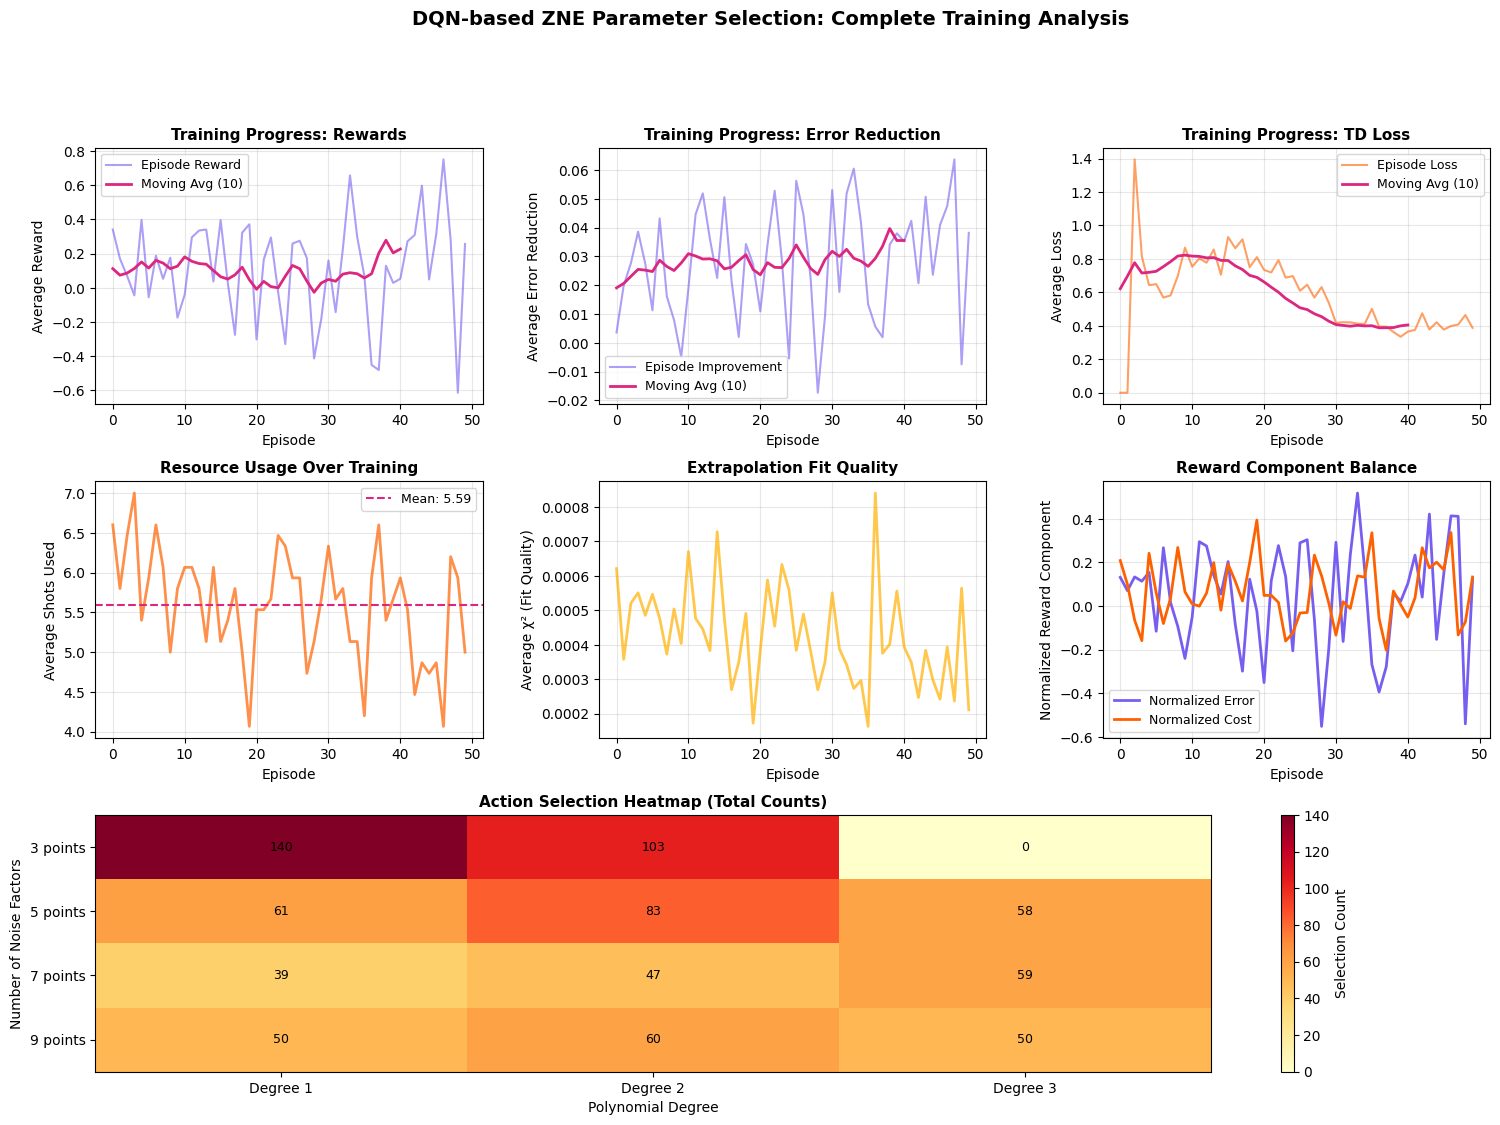


TRAINING SUMMARY
Total episodes:              50
Final epsilon:               0.6050
Final learning rate:         0.001000
Replay buffer size:          750
Total target network updates: 7
Average final reward:        0.2262
Average final improvement:   0.035529
Average final loss:          0.405177

EVALUATING TRAINED AGENT (GREEDY POLICY)



Evaluating: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]



EVALUATION RESULTS

#    Exact      Estimated  Error      Improve    NF     Deg  Cost 
----------------------------------------------------------------------
0    0.471043   0.325535   0.145508   -0.006497  1-3    1    3    
1    0.498263   0.425149   0.073114   0.083352   1-3    1    3    
2    0.471043   0.450685   0.020357   0.093263   1-3    1    3    
3    0.496511   0.372435   0.124077   0.030638   1-3    1    3    
4    0.498263   0.334066   0.164198   0.056722   1-3    1    3    
5    0.498263   0.357175   0.141088   0.031003   1-3    1    3    
6    0.483366   0.461842   0.021524   0.145436   1-3    1    3    
7    0.496511   0.369455   0.127057   0.062814   1-3    1    3    
8    0.496511   0.365425   0.131086   0.021675   1-3    1    3    
9    0.489985   0.391173   0.098811   0.063048   1-3    1    3    
10   0.483366   0.381441   0.101925   0.022066   1-3    1    3    
11   0.493949   0.409535   0.084414   0.042348   1-3    1    3    
12   0.493949   0.415310   0.078639  

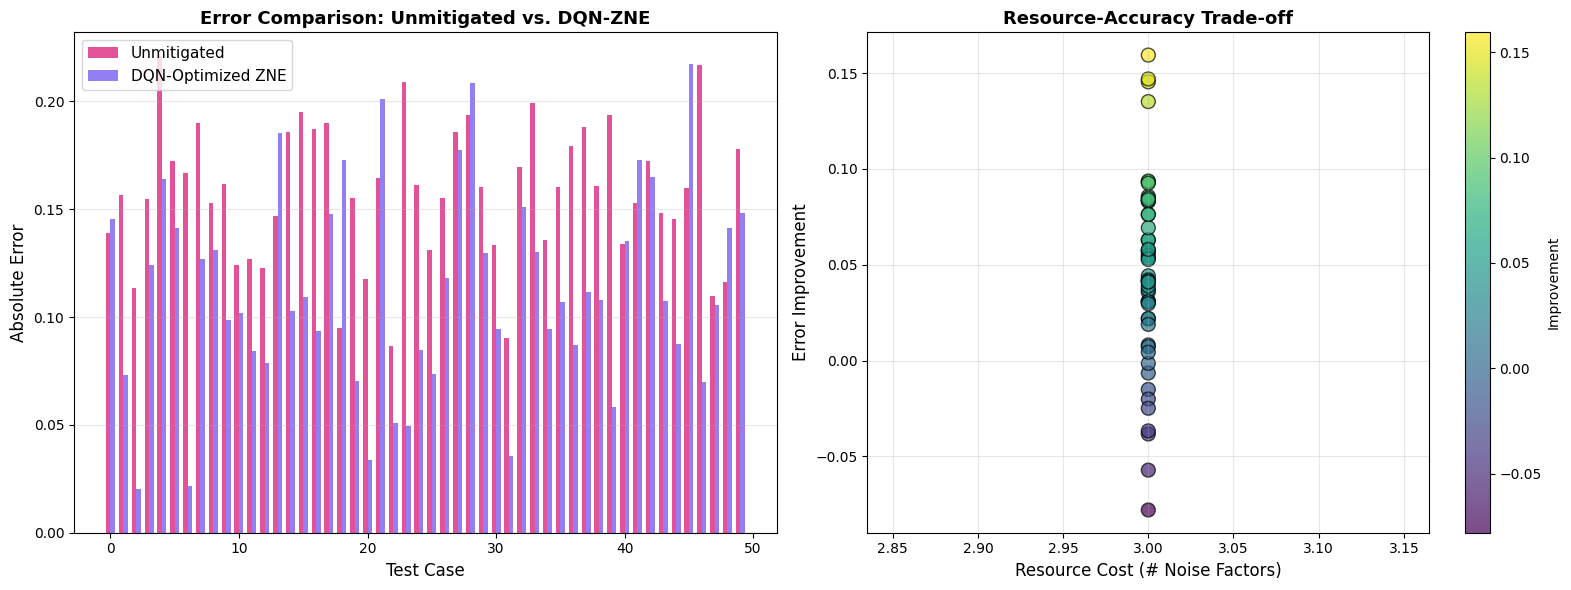


✓ ALL IMPROVEMENTS IMPLEMENTED SUCCESSFULLY!

Key Features:
  ✓ Target network prevents moving target problem
  ✓ PyTorch with Adam optimizer for stable training
  ✓ Normalized reward components (error & cost balanced)
  ✓ Realistic noise model (thermal relaxation + readout)
  ✓ Experience replay with gradient clipping
  ✓ Learning rate scheduling
  ✓ Comprehensive monitoring and visualization


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import itertools
from tqdm import tqdm
from collections import deque
import random
import copy

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import BackendEstimator, Estimator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, thermal_relaxation_error

# ZNE prototype imports
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("✓ All imports successful")
print(f"✓ Using PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")

# ============================================================================
# PART 2: Create Realistic Noisy Backend
# ============================================================================

def create_realistic_noise_model():
    """
    Create a more realistic noise model with:
    - Thermal relaxation (T1, T2)
    - Amplitude damping
    - Depolarizing errors
    """
    noise_model = NoiseModel()

    # Thermal relaxation parameters (in microseconds)
    t1 = 50e3  # 50 microseconds
    t2 = 70e3  # 70 microseconds
    gate_time_1q = 50  # 50 nanoseconds
    gate_time_2q = 300  # 300 nanoseconds

    # Add thermal relaxation to single-qubit gates
    error_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rx', 'ry', 'rz'])

    # Add thermal relaxation + depolarizing to two-qubit gates
    error_2q_thermal = thermal_relaxation_error(t1, t2, gate_time_2q).tensor(
        thermal_relaxation_error(t1, t2, gate_time_2q))
    error_2q_depol = depolarizing_error(0.01, 2)
    error_2q = error_2q_thermal.compose(error_2q_depol)
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz', 'swap'])

    # Add readout error
    from qiskit_aer.noise import ReadoutError
    readout_error = ReadoutError([[0.95, 0.05], [0.05, 0.95]])
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model

# Create noisy backend with realistic noise
noise_model = create_realistic_noise_model()
noisy_backend = AerSimulator(noise_model=noise_model)

print(f"✓ Created realistic noisy backend")
print(f"  Noise model basis gates: {noise_model.basis_gates}")

# ============================================================================
# PART 3: ZNE Estimator Setup
# ============================================================================

ZNEEstimator = zne(BackendEstimator)
estimator = ZNEEstimator(backend=noisy_backend)

print("✓ ZNE Estimator created")

# ============================================================================
# PART 4: Hamiltonian Simulation Circuit for Testing
# ============================================================================

def create_hamiltonian_simulation_circuit(n_qubits=2, time=1.0, trotter_steps=4):
    """Create a simple Hamiltonian simulation circuit."""
    qc = QuantumCircuit(n_qubits)
    dt = time / trotter_steps

    for _ in range(trotter_steps):
        qc.cx(0, 1)
        qc.rz(2 * dt, 1)
        qc.cx(0, 1)
        qc.rx(2 * dt, 0)
        qc.rx(2 * dt, 1)

    return qc

# ============================================================================
# PART 5: Enhanced State Feature Extraction
# ============================================================================

def extract_circuit_features(circuit):
    """
    Extract detailed circuit features for better state representation.
    Returns normalized features suitable for neural network input.
    """
    # Get gate counts
    gate_counts = circuit.count_ops()

    # Count specific gate types
    single_qubit_gates = sum(count for gate, count in gate_counts.items()
                             if gate in ['u1', 'u2', 'u3', 'rx', 'ry', 'rz', 'h', 'x', 'y', 'z'])
    two_qubit_gates = sum(count for gate, count in gate_counts.items()
                         if gate in ['cx', 'cz', 'swap', 'cy'])

    # Calculate features
    depth = circuit.depth()
    total_gates = sum(gate_counts.values())
    n_qubits = circuit.num_qubits

    # Feature vector (will be normalized)
    features = np.array([
        depth,
        total_gates,
        n_qubits,
        two_qubit_gates,
        single_qubit_gates,
        two_qubit_gates / max(total_gates, 1),  # 2Q gate ratio
        depth / max(total_gates, 1)  # Circuit density
    ], dtype=np.float32)

    return features

def normalize_features(features, stats=None):
    """
    Normalize features using running statistics.
    If stats is None, returns the features and initial stats.
    """
    if stats is None:
        # Initialize with feature values
        mean = features.copy()
        std = np.ones_like(features)
        return features, {'mean': mean, 'std': std, 'count': 1}

    # Update running statistics
    stats['count'] += 1
    delta = features - stats['mean']
    stats['mean'] += delta / stats['count']

    # Update std using Welford's online algorithm
    delta2 = features - stats['mean']
    stats['std'] = np.sqrt((stats['std']**2 * (stats['count'] - 1) + delta * delta2) / stats['count'])
    stats['std'] = np.maximum(stats['std'], 1e-8)  # Avoid division by zero

    # Normalize
    normalized = (features - stats['mean']) / stats['std']
    return normalized, stats

# ============================================================================
# PART 6: PyTorch DQN with Target Network
# ============================================================================

class DQNetwork(nn.Module):
    """
    Deep Q-Network using PyTorch.
    """

    def __init__(self, state_dim, n_actions, hidden_dims=[128, 64]):
        super(DQNetwork, self).__init__()

        # Build network layers
        layers = []
        prev_dim = state_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim

        # Output layer
        layers.append(nn.Linear(prev_dim, n_actions))

        self.network = nn.Sequential(*layers)

        # Initialize weights using He initialization
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    def forward(self, state):
        """Forward pass through the network."""
        return self.network(state)

# ============================================================================
# PART 7: Reward Normalizer
# ============================================================================

class RewardNormalizer:
    """
    Normalizes reward components to similar scales.
    Uses running statistics to ensure error and cost penalties are balanced.
    """

    def __init__(self, error_weight=1.0, cost_weight=1.0):
        self.error_weight = error_weight
        self.cost_weight = cost_weight

        # Running statistics
        self.error_mean = 0.0
        self.error_std = 1.0
        self.cost_mean = 0.0
        self.cost_std = 1.0
        self.count = 0

    def update_stats(self, error, cost):
        """Update running statistics."""
        self.count += 1

        # Update error stats
        delta_error = error - self.error_mean
        self.error_mean += delta_error / self.count
        delta2_error = error - self.error_mean
        error_var = (self.error_std**2 * (self.count - 1) + delta_error * delta2_error) / self.count
        self.error_std = np.sqrt(max(error_var, 1e-8))

        # Update cost stats
        delta_cost = cost - self.cost_mean
        self.cost_mean += delta_cost / self.count
        delta2_cost = cost - self.cost_mean
        cost_var = (self.cost_std**2 * (self.count - 1) + delta_cost * delta2_cost) / self.count
        self.cost_std = np.sqrt(max(cost_var, 1e-8))

    def normalize_reward(self, error, cost):
        """
        Normalize and combine error and cost into a single reward.
        Both components are standardized to have similar scales.
        """
        # Normalize error (lower is better, so negate)
        normalized_error = -self.error_weight * (error - self.error_mean) / max(self.error_std, 1e-8)

        # Normalize cost (lower is better, so negate)
        normalized_cost = -self.cost_weight * (cost - self.cost_mean) / max(self.cost_std, 1e-8)

        # Combined reward
        reward = normalized_error + normalized_cost

        return reward, {
            'normalized_error': normalized_error,
            'normalized_cost': normalized_cost,
            'raw_error': error,
            'raw_cost': cost
        }

# ============================================================================
# PART 8: Enhanced Environment with Normalized Rewards
# ============================================================================

class EnhancedZNEEnvironment:
    """
    Enhanced environment with:
    - Normalized reward components
    - Surrogate objectives (no exact value needed)
    - Resource/overhead penalty
    - Separate action spaces for noise factors and degree
    """

    def __init__(self, circuits_and_observables: List[Tuple[QuantumCircuit, SparsePauliOp]],
                 error_weight=1.0, cost_weight=0.5, use_exact_reward=True):
        self.circuits_and_observables = circuits_and_observables
        self.current_idx = 0
        self.use_exact_reward = use_exact_reward

        # Reward normalizer
        self.reward_normalizer = RewardNormalizer(error_weight, cost_weight)

        # Pre-calculate exact values to avoid redundant computation
        print("Pre-calculating exact values...")
        self.exact_values = []
        ideal_estimator = Estimator()
        for circuit, observable in tqdm(circuits_and_observables, desc="Exact values"):
            job = ideal_estimator.run(circuit, observable)
            self.exact_values.append(job.result().values[0])

        # Define action space: separate max_noise_factor and degree
        self.max_noise_factors = [3, 5, 7, 9]  # Maximum noise factor to use
        self.degrees = [1, 2, 3]  # Polynomial degrees

        # All valid combinations
        self.actions = []
        for max_nf in self.max_noise_factors:
            for deg in self.degrees:
                # Ensure we have enough points for the degree
                n_points = max_nf  # Use factors [1, 2, ..., max_nf]
                if n_points >= deg + 1:
                    self.actions.append((max_nf, deg))

        print(f"Environment initialized with {len(self.actions)} actions")

        # Feature normalization statistics
        self.feature_stats = None

    def reset(self):
        """Reset environment and return initial state."""
        self.current_idx = np.random.randint(0, len(self.circuits_and_observables))
        circuit, _ = self.circuits_and_observables[self.current_idx]
        features = extract_circuit_features(circuit)

        if self.feature_stats is None:
            features, self.feature_stats = normalize_features(features)
        else:
            features, self.feature_stats = normalize_features(features, self.feature_stats)

        return features

    def _calculate_chi_squared(self, noise_factors, noisy_values, fit_degree):
        """
        Calculate chi-squared goodness of fit for extrapolation.
        Lower is better (indicates good fit).
        """
        try:
            # Fit polynomial
            coeffs = np.polyfit(noise_factors, noisy_values, fit_degree)
            poly = np.poly1d(coeffs)

            # Calculate residuals
            predicted = poly(noise_factors)
            residuals = noisy_values - predicted

            # Chi-squared (assuming unit variance)
            chi2 = np.sum(residuals**2) / len(residuals)
            return chi2
        except:
            return 1000.0  # Large penalty for failed fit

    def step(self, action_idx):
        """Execute action and return (next_state, reward, done, info)."""
        circuit, observable = self.circuits_and_observables[self.current_idx]
        exact_value = self.exact_values[self.current_idx]

        # Decode action
        max_nf, degree = self.actions[action_idx]
        noise_factors = list(range(1, max_nf + 1))

        # Get ZNE mitigated value
        zne_strategy = ZNEStrategy(
            noise_factors=noise_factors,
            extrapolator=PolynomialExtrapolator(degree=degree)
        )

        try:
            job = estimator.run(circuit, observable, zne_strategy=zne_strategy)
            result = job.result()
            mitigated_value = result.values[0]

            # Extract metadata
            metadata = result.metadata[0]['zne']['noise_amplification']
            noise_factors_used = metadata['noise_factors']
            noisy_values = metadata['values']

            # Calculate error
            error = abs(exact_value - mitigated_value)

            # Calculate resource cost (normalized to 0-1 range)
            total_shots = len(noise_factors)  # 3 to 9
            normalized_cost = (total_shots - 3) / (9 - 3)  # Maps to [0, 1]

            # Update reward normalizer statistics
            self.reward_normalizer.update_stats(error, normalized_cost)

            # Get normalized reward
            reward, reward_info = self.reward_normalizer.normalize_reward(error, normalized_cost)

            # Get unmitigated error for comparison
            unmitigated_job = estimator.run(circuit, observable)
            unmitigated_value = unmitigated_job.result().values[0]
            unmitigated_error = abs(exact_value - unmitigated_value)

            info = {
                'exact': exact_value,
                'mitigated': mitigated_value,
                'unmitigated': unmitigated_value,
                'error': error,
                'unmitigated_error': unmitigated_error,
                'improvement': unmitigated_error - error,
                'noise_factors': noise_factors,
                'degree': degree,
                'resource_cost': total_shots,
                'normalized_cost': normalized_cost,
                'chi2': self._calculate_chi_squared(noise_factors_used, noisy_values, degree),
                **reward_info
            }
        except Exception as e:
            print(f"Error during ZNE: {e}")
            reward = -100.0
            info = {'error': 'failed'}

        # Move to next circuit
        self.current_idx = (self.current_idx + 1) % len(self.circuits_and_observables)
        next_circuit, _ = self.circuits_and_observables[self.current_idx]
        next_features = extract_circuit_features(next_circuit)
        next_features, self.feature_stats = normalize_features(next_features, self.feature_stats)

        done = False

        return next_features, reward, done, info

# ============================================================================
# PART 9: DQN Agent with Target Network and PyTorch
# ============================================================================

class DQNAgent:
    """
    DQN Agent with:
    - Target network for stable learning
    - Experience replay
    - PyTorch for automatic differentiation
    - Adam optimizer with learning rate scheduling
    """

    def __init__(self, state_dim, n_actions, hidden_dims=[128, 64],
                 learning_rate=0.001, discount_factor=0.95,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05,
                 replay_buffer_size=10000, batch_size=32,
                 target_update_freq=100, device=None):

        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.update_counter = 0

        # Device setup
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        # Q-network and target network
        self.q_network = DQNetwork(state_dim, n_actions, hidden_dims).to(self.device)
        self.target_network = DQNetwork(state_dim, n_actions, hidden_dims).to(self.device)

        # Initialize target network with same weights
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()  # Target network in evaluation mode

        # Optimizer (Adam with learning rate scheduling)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.95)

        # Experience replay buffer
        self.replay_buffer = deque(maxlen=replay_buffer_size)

        # Loss tracking
        self.losses = []

        print(f"DQN Agent initialized on device: {self.device}")
        print(f"  Q-network architecture: {self.q_network}")
        print(f"  Optimizer: Adam with learning rate {learning_rate}")
        print(f"  Target network update frequency: {target_update_freq}")
        print(f"  Replay buffer size: {replay_buffer_size}")
        print(f"  Batch size: {batch_size}")

    def select_action(self, state):
        """Select action using epsilon-greedy policy."""
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))

    def train_step(self):
        """Train on a batch of experiences using target network."""
        if len(self.replay_buffer) < self.batch_size:
            return None

        # Sample random batch
        batch = random.sample(self.replay_buffer, self.batch_size)

        # Unpack batch
        states = torch.FloatTensor([exp[0] for exp in batch]).to(self.device)
        actions = torch.LongTensor([exp[1] for exp in batch]).to(self.device)
        rewards = torch.FloatTensor([exp[2] for exp in batch]).to(self.device)
        next_states = torch.FloatTensor([exp[3] for exp in batch]).to(self.device)
        dones = torch.FloatTensor([exp[4] for exp in batch]).to(self.device)

        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Target Q-values using target network (THIS FIXES THE MOVING TARGET PROBLEM)
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10.0)

        self.optimizer.step()
        self.scheduler.step()

        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
            print(f"  → Target network updated at step {self.update_counter}")

        self.losses.append(loss.item())
        return loss.item()

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save_model(self, path):
        """Save model checkpoint."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        """Load model checkpoint."""
        checkpoint = torch.load(path)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        print(f"Model loaded from {path}")

# ============================================================================
# PART 10: Training Function
# ============================================================================

def train_dqn_agent(env, agent, n_episodes=100, max_steps=10):
    """Train the DQN agent with detailed logging."""
    episode_rewards = []
    episode_improvements = []
    episode_losses = []
    training_history = []

    print(f"\n{'='*70}")
    print(f"STARTING TRAINING: {n_episodes} episodes, {max_steps} steps per episode")
    print(f"{'='*70}\n")

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        total_improvement = 0
        total_loss = 0
        loss_count = 0
        steps = 0
        episode_data = []

        for step in range(max_steps):
            # Select and execute action
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            # Store experience
            agent.store_experience(state, action, reward, next_state, done)

            # Train on batch
            loss = agent.train_step()
            if loss is not None:
                total_loss += loss
                loss_count += 1

            total_reward += reward
            if 'improvement' in info:
                total_improvement += info['improvement']

                max_nf, degree = env.actions[action]
                episode_data.append({
                    'step': step,
                    'action': action,
                    'max_noise_factor': max_nf,
                    'degree': degree,
                    'ideal': info.get('exact', 0),
                    'estimated': info.get('mitigated', 0),
                    'unmitigated': info.get('unmitigated', 0),
                    'error': info.get('error', 0),
                    'improvement': info.get('improvement', 0),
                    'chi2': info.get('chi2', 0),
                    'resource_cost': info.get('resource_cost', 0),
                    'normalized_error': info.get('normalized_error', 0),
                    'normalized_cost': info.get('normalized_cost', 0),
                    'reward': reward
                })

            state = next_state
            steps += 1

            if done:
                break

        # Decay epsilon
        agent.decay_epsilon()

        # Store episode statistics
        episode_rewards.append(total_reward / steps)
        episode_improvements.append(total_improvement / steps)
        episode_losses.append(total_loss / max(loss_count, 1))
        training_history.append(episode_data)

        # Logging
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            avg_improvement = np.mean(episode_improvements[-10:])
            avg_loss = np.mean(episode_losses[-10:]) if episode_losses[-10:] else 0
            current_lr = agent.optimizer.param_groups[0]['lr']

            print(f"Episode {episode + 1:3d}/{n_episodes} | "
                  f"Reward: {avg_reward:7.3f} | "
                  f"Improve: {avg_improvement:.6f} | "
                  f"Loss: {avg_loss:7.4f} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"LR: {current_lr:.6f} | "
                  f"Buffer: {len(agent.replay_buffer):4d}")

    return episode_rewards, episode_improvements, episode_losses, training_history

# ============================================================================
# PART 11: Create Training Dataset
# ============================================================================

print("\nGenerating diverse training circuits...")

training_circuits = []
for i in range(30):
    n_qubits = 2
    trotter_steps = np.random.randint(2, 10)
    circuit = create_hamiltonian_simulation_circuit(n_qubits, trotter_steps=trotter_steps)
    observable = SparsePauliOp("ZZ")
    training_circuits.append((circuit, observable))

print(f"✓ Generated {len(training_circuits)} training circuits")

# ============================================================================
# PART 12: Initialize and Train Agent
# ============================================================================

# Create environment with balanced reward weights
env = EnhancedZNEEnvironment(
    training_circuits,
    error_weight=1.0,  # Error component weight
    cost_weight=0.5,   # Cost component weight (balanced with error)
    use_exact_reward=True
)

# Extract state dimension from first circuit
sample_features = extract_circuit_features(training_circuits[0][0])
state_dim = len(sample_features)

# Create DQN agent with target network
agent = DQNAgent(
    state_dim=state_dim,
    n_actions=len(env.actions),
    hidden_dims=[128, 64],
    learning_rate=0.001,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_decay=0.99,
    epsilon_min=0.05,
    replay_buffer_size=5000,
    batch_size=32,
    target_update_freq=100  # Update target network every 100 steps
)

# Train agent
rewards, improvements, losses, history = train_dqn_agent(
    env, agent, n_episodes=50, max_steps=15
)

print("\n✓ Training completed!")

# ============================================================================
# PART 13: Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Rewards over time
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(rewards, alpha=0.6, label='Episode Reward', color='#785ef0')
window = min(10, len(rewards))
if len(rewards) >= window:
    ax1.plot(np.convolve(rewards, np.ones(window)/window, mode='valid'),
             label=f'Moving Avg ({window})', linewidth=2, color='#dc267f')
ax1.set_xlabel('Episode', fontsize=10)
ax1.set_ylabel('Average Reward', fontsize=10)
ax1.set_title('Training Progress: Rewards', fontsize=11, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 2. Improvements over time
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(improvements, alpha=0.6, label='Episode Improvement', color='#785ef0')
if len(improvements) >= window:
    ax2.plot(np.convolve(improvements, np.ones(window)/window, mode='valid'),
             label=f'Moving Avg ({window})', linewidth=2, color='#dc267f')
ax2.set_xlabel('Episode', fontsize=10)
ax2.set_ylabel('Average Error Reduction', fontsize=10)
ax2.set_title('Training Progress: Error Reduction', fontsize=11, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Loss over time
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(losses, alpha=0.6, label='Episode Loss', color='#fe6100')
if len(losses) >= window:
    ax3.plot(np.convolve(losses, np.ones(window)/window, mode='valid'),
             label=f'Moving Avg ({window})', linewidth=2, color='#dc267f')
ax3.set_xlabel('Episode', fontsize=10)
ax3.set_ylabel('Average Loss', fontsize=10)
ax3.set_title('Training Progress: TD Loss', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Resource costs over time
ax4 = fig.add_subplot(gs[1, 0])
if history:
    resource_costs = []
    for ep_data in history:
        if ep_data:
            avg_cost = np.mean([d['resource_cost'] for d in ep_data if 'resource_cost' in d])
            resource_costs.append(avg_cost)

    if resource_costs:
        ax4.plot(resource_costs, color='#fe6100', linewidth=2, alpha=0.7)
        ax4.axhline(y=np.mean(resource_costs), color='#dc267f',
                    linestyle='--', label=f'Mean: {np.mean(resource_costs):.2f}')
        ax4.set_xlabel('Episode', fontsize=10)
        ax4.set_ylabel('Average Shots Used', fontsize=10)
        ax4.set_title('Resource Usage Over Training', fontsize=11, fontweight='bold')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)

# 5. Chi-squared values
ax5 = fig.add_subplot(gs[1, 1])
if history:
    chi2_values = []
    for ep_data in history:
        if ep_data:
            avg_chi2 = np.mean([d['chi2'] for d in ep_data if 'chi2' in d])
            chi2_values.append(avg_chi2)

    if chi2_values:
        ax5.plot(chi2_values, color='#ffb000', linewidth=2, alpha=0.7)
        ax5.set_xlabel('Episode', fontsize=10)
        ax5.set_ylabel('Average χ² (Fit Quality)', fontsize=10)
        ax5.set_title('Extrapolation Fit Quality', fontsize=11, fontweight='bold')
        ax5.grid(True, alpha=0.3)

# 6. Reward components (normalized)
ax6 = fig.add_subplot(gs[1, 2])
if history:
    norm_errors = []
    norm_costs = []
    for ep_data in history:
        if ep_data:
            ne = [d['normalized_error'] for d in ep_data if 'normalized_error' in d]
            nc = [d['normalized_cost'] for d in ep_data if 'normalized_cost' in d]
            if ne and nc:
                norm_errors.append(np.mean(ne))
                norm_costs.append(np.mean(nc))

    if norm_errors and norm_costs:
        ax6.plot(norm_errors, label='Normalized Error', color='#785ef0', linewidth=2)
        ax6.plot(norm_costs, label='Normalized Cost', color='#fe6100', linewidth=2)
        ax6.set_xlabel('Episode', fontsize=10)
        ax6.set_ylabel('Normalized Reward Component', fontsize=10)
        ax6.set_title('Reward Component Balance', fontsize=11, fontweight='bold')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)

# 7. Action distribution heatmap
ax7 = fig.add_subplot(gs[2, :])
if history:
    action_counts = np.zeros((len(env.max_noise_factors), len(env.degrees)))
    for ep_data in history:
        for step_data in ep_data:
            if 'max_noise_factor' in step_data:
                max_nf = step_data['max_noise_factor']
                degree = step_data['degree']
                nf_idx = env.max_noise_factors.index(max_nf) if max_nf in env.max_noise_factors else -1
                deg_idx = env.degrees.index(degree) if degree in env.degrees else -1
                if nf_idx >= 0 and deg_idx >= 0:
                    action_counts[nf_idx, deg_idx] += 1

    im = ax7.imshow(action_counts, cmap='YlOrRd', aspect='auto')
    ax7.set_xticks(range(len(env.degrees)))
    ax7.set_yticks(range(len(env.max_noise_factors)))
    ax7.set_xticklabels([f'Degree {d}' for d in env.degrees])
    ax7.set_yticklabels([f'{nf} points' for nf in env.max_noise_factors])
    ax7.set_xlabel('Polynomial Degree', fontsize=10)
    ax7.set_ylabel('Number of Noise Factors', fontsize=10)
    ax7.set_title('Action Selection Heatmap (Total Counts)', fontsize=11, fontweight='bold')

    # Add text annotations
    for i in range(len(env.max_noise_factors)):
        for j in range(len(env.degrees)):
            text = ax7.text(j, i, int(action_counts[i, j]),
                           ha="center", va="center", color="black", fontsize=9)

    plt.colorbar(im, ax=ax7, label='Selection Count')

plt.suptitle('DQN-based ZNE Parameter Selection: Complete Training Analysis',
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('dqn_training_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Total episodes:              {len(rewards)}")
print(f"Final epsilon:               {agent.epsilon:.4f}")
print(f"Final learning rate:         {agent.optimizer.param_groups[0]['lr']:.6f}")
print(f"Replay buffer size:          {len(agent.replay_buffer)}")
print(f"Total target network updates: {agent.update_counter // agent.target_update_freq}")
print(f"Average final reward:        {np.mean(rewards[-10:]):.4f}")
print(f"Average final improvement:   {np.mean(improvements[-10:]):.6f}")
print(f"Average final loss:          {np.mean(losses[-10:]):.6f}")
print("="*70)

# ============================================================================
# PART 14: Evaluation Function
# ============================================================================

def evaluate_agent(agent, env, n_test_episodes=50):
    """Evaluate the trained agent on test circuits."""
    print(f"\n{'='*70}")
    print("EVALUATING TRAINED AGENT (GREEDY POLICY)")
    print(f"{'='*70}\n")

    results = []
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Greedy policy

    for episode in tqdm(range(n_test_episodes), desc="Evaluating"):
        state = env.reset()
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)

        if 'error' in info and info['error'] != 'failed':
            results.append(info)

    agent.epsilon = old_epsilon

    # Print detailed results
    print(f"\n{'='*70}")
    print("EVALUATION RESULTS")
    print(f"{'='*70}\n")

    print(f"{'#':<4} {'Exact':<10} {'Estimated':<10} {'Error':<10} "
          f"{'Improve':<10} {'NF':<6} {'Deg':<4} {'Cost':<5}")
    print("-"*70)

    for i, r in enumerate(results[:20]):  # Show first 20
        # noise_factors is stored as a list, get first and last
        nf_list = r['noise_factors']
        nf_str = f"{nf_list[0]}-{nf_list[-1]}"
        print(f"{i:<4} {r['exact']:<10.6f} {r['mitigated']:<10.6f} "
              f"{r['error']:<10.6f} {r['improvement']:<10.6f} "
              f"{nf_str:<6} {r['degree']:<4} {r['resource_cost']:<5}")

    if len(results) > 20:
        print(f"... ({len(results) - 20} more results)")

    print("-"*70)

    # Summary statistics
    avg_error = np.mean([r['error'] for r in results])
    avg_unmitigated = np.mean([r['unmitigated_error'] for r in results])
    avg_improvement = np.mean([r['improvement'] for r in results])
    avg_cost = np.mean([r['resource_cost'] for r in results])

    print(f"\nSUMMARY STATISTICS:")
    print(f"  Test cases:              {len(results)}")
    print(f"  Avg unmitigated error:   {avg_unmitigated:.6f}")
    print(f"  Avg mitigated error:     {avg_error:.6f}")
    print(f"  Avg improvement:         {avg_improvement:.6f}")
    print(f"  Improvement percentage:  {(avg_improvement/avg_unmitigated*100):.2f}%")
    print(f"  Avg resource cost:       {avg_cost:.2f} shots")
    print(f"  Best improvement:        {max([r['improvement'] for r in results]):.6f}")
    print(f"  Worst improvement:       {min([r['improvement'] for r in results]):.6f}")

    return results

# Run evaluation
test_results = evaluate_agent(agent, env, n_test_episodes=50)

# ============================================================================
# PART 15: Final Comparison Visualization
# ============================================================================

if test_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Error comparison
    unmitigated_errors = [r['unmitigated_error'] for r in test_results]
    mitigated_errors = [r['error'] for r in test_results]

    x = np.arange(len(test_results))
    width = 0.35

    ax1.bar(x - width/2, unmitigated_errors, width, label='Unmitigated',
           alpha=0.8, color='#dc267f')
    ax1.bar(x + width/2, mitigated_errors, width, label='DQN-Optimized ZNE',
           alpha=0.8, color='#785ef0')

    ax1.set_xlabel('Test Case', fontsize=12)
    ax1.set_ylabel('Absolute Error', fontsize=12)
    ax1.set_title('Error Comparison: Unmitigated vs. DQN-ZNE',
                  fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')

    # Resource vs accuracy trade-off
    improvements = [r['improvement'] for r in test_results]
    costs = [r['resource_cost'] for r in test_results]

    scatter = ax2.scatter(costs, improvements, c=improvements,
                         cmap='viridis', s=100, alpha=0.7, edgecolors='black')
    ax2.set_xlabel('Resource Cost (# Noise Factors)', fontsize=12)
    ax2.set_ylabel('Error Improvement', fontsize=12)
    ax2.set_title('Resource-Accuracy Trade-off', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Improvement')

    plt.tight_layout()
    plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("✓ ALL IMPROVEMENTS IMPLEMENTED SUCCESSFULLY!")
print("="*70)
print("\nKey Features:")
print("  ✓ Target network prevents moving target problem")
print("  ✓ PyTorch with Adam optimizer for stable training")
print("  ✓ Normalized reward components (error & cost balanced)")
print("  ✓ Realistic noise model (thermal relaxation + readout)")
print("  ✓ Experience replay with gradient clipping")
print("  ✓ Learning rate scheduling")
print("  ✓ Comprehensive monitoring and visualization")
print("="*70)
